### Window

Szűrőrend (N): 243, Kaiser β: 5.65


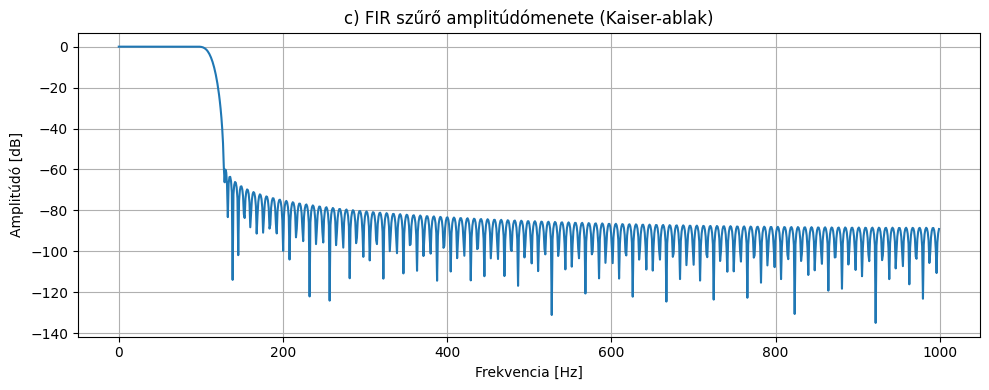

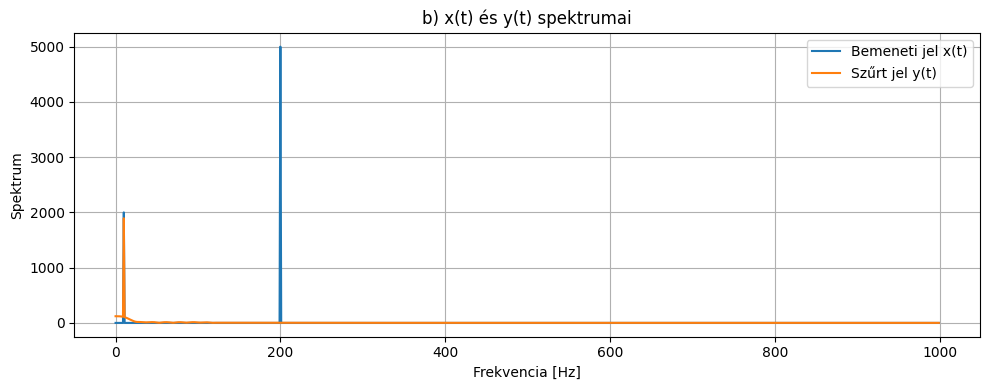

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import kaiserord, firwin, lfilter, freqz
from scipy.fft import fft, fftfreq

# Paraméterek
fs = 2000         # Mintavételi frekvencia
f0 = 113          # Vágási frekvencia
delta_p = 0.1     # Átviteli sáv hullámzás (dB)
delta_s = 60      # Zárlási sáv csillapítás (dB)
transition_width = 30  # Hz, becsült átmeneti sáv

# a) Kaiser-ablak paraméterei és FIR szűrő tervezés
nyq_rate = fs / 2
width = transition_width / nyq_rate  # normalizált sávszélesség
ripple_db = delta_s

N, beta = kaiserord(ripple_db, width)
if N % 2 == 0:
    N += 1  # páratlan szűrőhossz

print(f"Szűrőrend (N): {N}, Kaiser β: {beta:.2f}")

f_lp = 113
f_hp = 180
f_bp = (150, 400)
f_bs = (150, 450)

# 1. Aluláteresztő (Low-pass)
taps_lp = firwin(N, cutoff=f_lp, window=('kaiser', beta), fs=fs, pass_zero=True)

# 2. Felüláteresztő (High-pass)
taps_hp = firwin(N, cutoff=f_hp, window=('kaiser', beta), fs=fs, pass_zero=False)

# 3. Sáváteresztő (Band-pass)
taps_bp = firwin(N, cutoff=f_bp, window=('kaiser', beta), fs=fs, pass_zero=False)

# 4. Sávtartó (Band-stop)
taps_bs = firwin(N, cutoff=f_bs, window=('kaiser', beta), fs=fs, pass_zero=True)

taps = taps_lp


# c) Amplitúdómenet (frekvenciamenet)
w, h = freqz(taps, worN=1024, fs=fs)
plt.figure(figsize=(10, 4))
plt.plot(w, 20 * np.log10(np.abs(h)))
plt.title("c) FIR szűrő amplitúdómenete (Kaiser-ablak)")
plt.xlabel("Frekvencia [Hz]")
plt.ylabel("Amplitúdó [dB]")
plt.grid()
plt.tight_layout()
plt.show()

# b) Bemeneti jel generálása
t = np.arange(0, 1, 1/fs)
x = 2 * np.sin(20 * np.pi * t) + 5 * np.sin(400 * np.pi * t)

# Szűrés
y = lfilter(taps, 1.0, x)

# FFT (spektrum) számítás
def plot_spectrum(signal, fs, title):
    N = len(signal)
    f = fftfreq(N, d=1/fs)[:N//2]
    spectrum = np.abs(fft(signal))[:N//2]
    plt.plot(f, spectrum, label=title)

plt.figure(figsize=(10, 4))
plot_spectrum(x, fs, "Bemeneti jel x(t)")
plot_spectrum(y, fs, "Szűrt jel y(t)")
plt.title("b) x(t) és y(t) spektrumai")
plt.xlabel("Frekvencia [Hz]")
plt.ylabel("Spektrum")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


### Remez


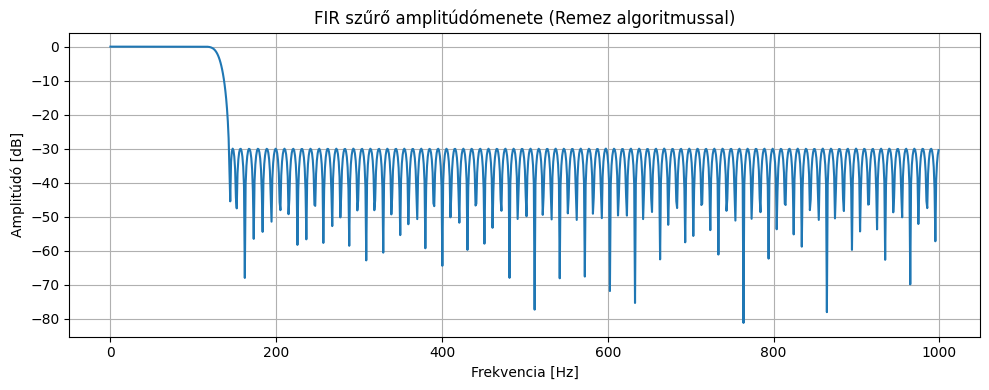

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import remez, lfilter, freqz
from scipy.fft import fft, fftfreq

# Paraméterek
fs = 2000
f0 = 113
delta_p = 0.1  # dB
delta_s = 60   # dB
transition_width = 30  # Hz
numtaps = 201

wp = 1 / (10**(delta_p / 20))
ws = 1 / (10**(delta_s / 20))

def remez_lp(f0, wp, ws, transition_width=30, numtaps=201):
    bands = [0, f0, f0 + transition_width, fs / 2]
    desired = [1, 0]
    weights = [wp, ws]

    taps_lp = remez(numtaps, bands, desired, weight=weights, fs=fs)
    return taps_lp

def remez_hp(cutoff, wp, ws, transition_width=30, numtaps=201):
    bands = [0, cutoff - transition_width, cutoff, fs / 2]
    desired = [0, 1]
    weights = [ws, wp]

    taps_hp = remez(numtaps, bands, desired, weight=weights, fs=fs)
    return taps_hp

def remez_bp(f1, f2, wp, ws, transition_width=50, numtaps=201):
    bands = [0, f1 - transition_width, f1, f2, f2 + transition_width, fs / 2]
    desired = [0, 1, 0]
    weights = [ws, wp, ws]

    taps_bp = remez(numtaps, bands, desired, weight=weights, fs=fs)
    return taps_bp

def remez_bs(f1, f2, wp, ws, transition_width=50, numtaps=201):
    bands = [0, f1 - transition_width, f1, f2, f2 + transition_width, fs / 2]
    desired = [1, 0, 1]
    weights = [wp, ws, wp]

    taps_bs = remez(numtaps, bands, desired, weight=weights, fs=fs)
    return taps_bs



taps = remez_lp(f0, wp, ws, transition_width=transition_width, numtaps=numtaps)
# taps = remez_hp(f0, wp, ws)
# taps = remez_bp(150, 300, wp, ws)
# taps = remez_bs(150, 300, wp, ws)

# Frekvenciamenet
w, h = freqz(taps, worN=1024, fs=fs)
plt.figure(figsize=(10, 4))
plt.plot(w, 20 * np.log10(np.abs(h)), label="Remez FIR")
plt.title("FIR szűrő amplitúdómenete (Remez algoritmussal)")
plt.xlabel("Frekvencia [Hz]")
plt.ylabel("Amplitúdó [dB]")
plt.grid()
plt.tight_layout()
plt.show()


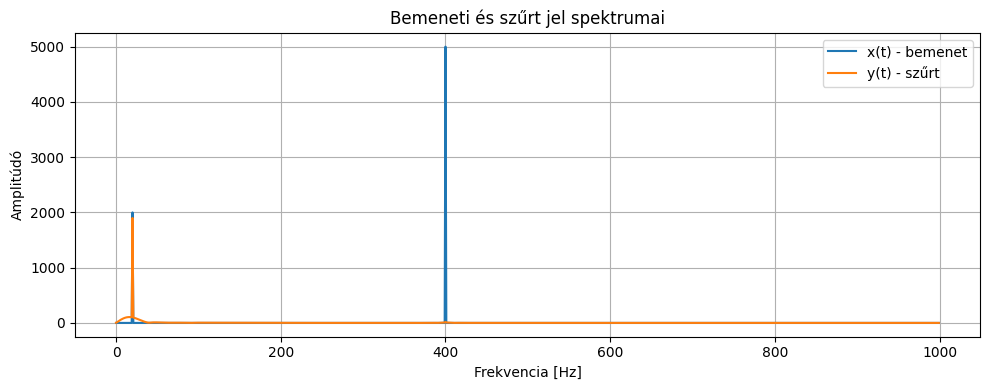

In [ ]:
# Idő és jel
t = np.arange(0, 1, 1/fs)
x = 2 * np.sin(20 * np.pi * t) + 5 * np.sin(400 * np.pi * t)
y = lfilter(taps, 1.0, x)

# Spektrumok
def plot_spectrum(signal, fs, label):
    N = len(signal)
    f = fftfreq(N, 1/fs)[:N//2]
    spec = np.abs(fft(signal))[:N//2]
    plt.plot(f, spec, label=label)

plt.figure(figsize=(10, 4))
plot_spectrum(x, fs, "x(t) - bemenet")
plot_spectrum(y, fs, "y(t) - szűrt")
plt.title("Bemeneti és szűrt jel spektrumai")
plt.xlabel("Frekvencia [Hz]")
plt.ylabel("Amplitúdó")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()
